# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [1]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0)
]

In [4]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

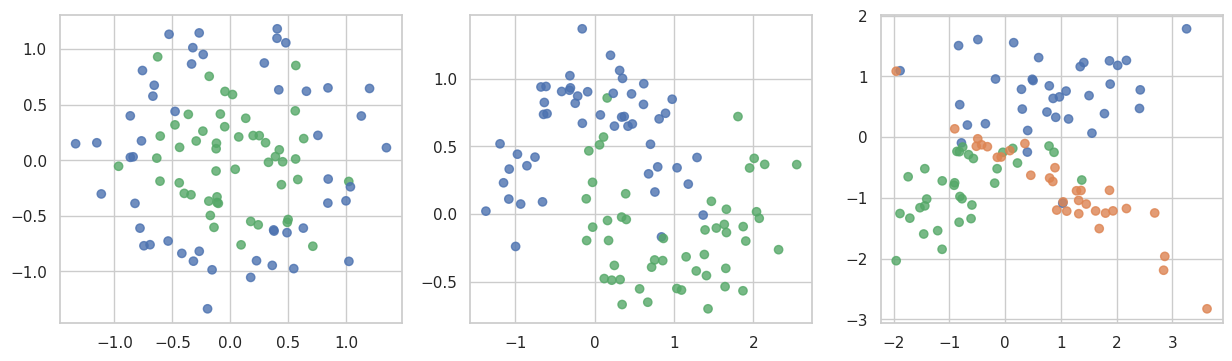

In [5]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [6]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

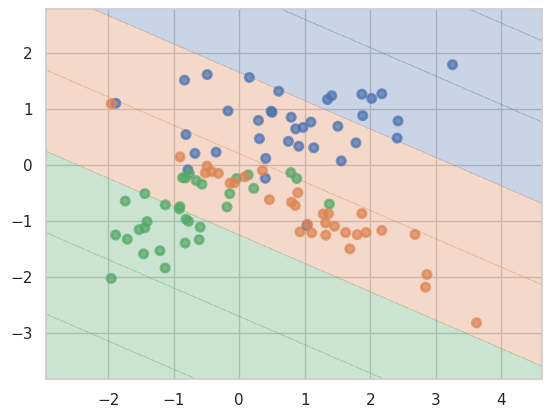

In [7]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

Dataset 1:
Train accuracy: 1.000
Test accuracy: 0.733
---
Dataset 2:
Train accuracy: 1.000
Test accuracy: 0.867
---
Dataset 3:
Train accuracy: 1.000
Test accuracy: 0.833
---


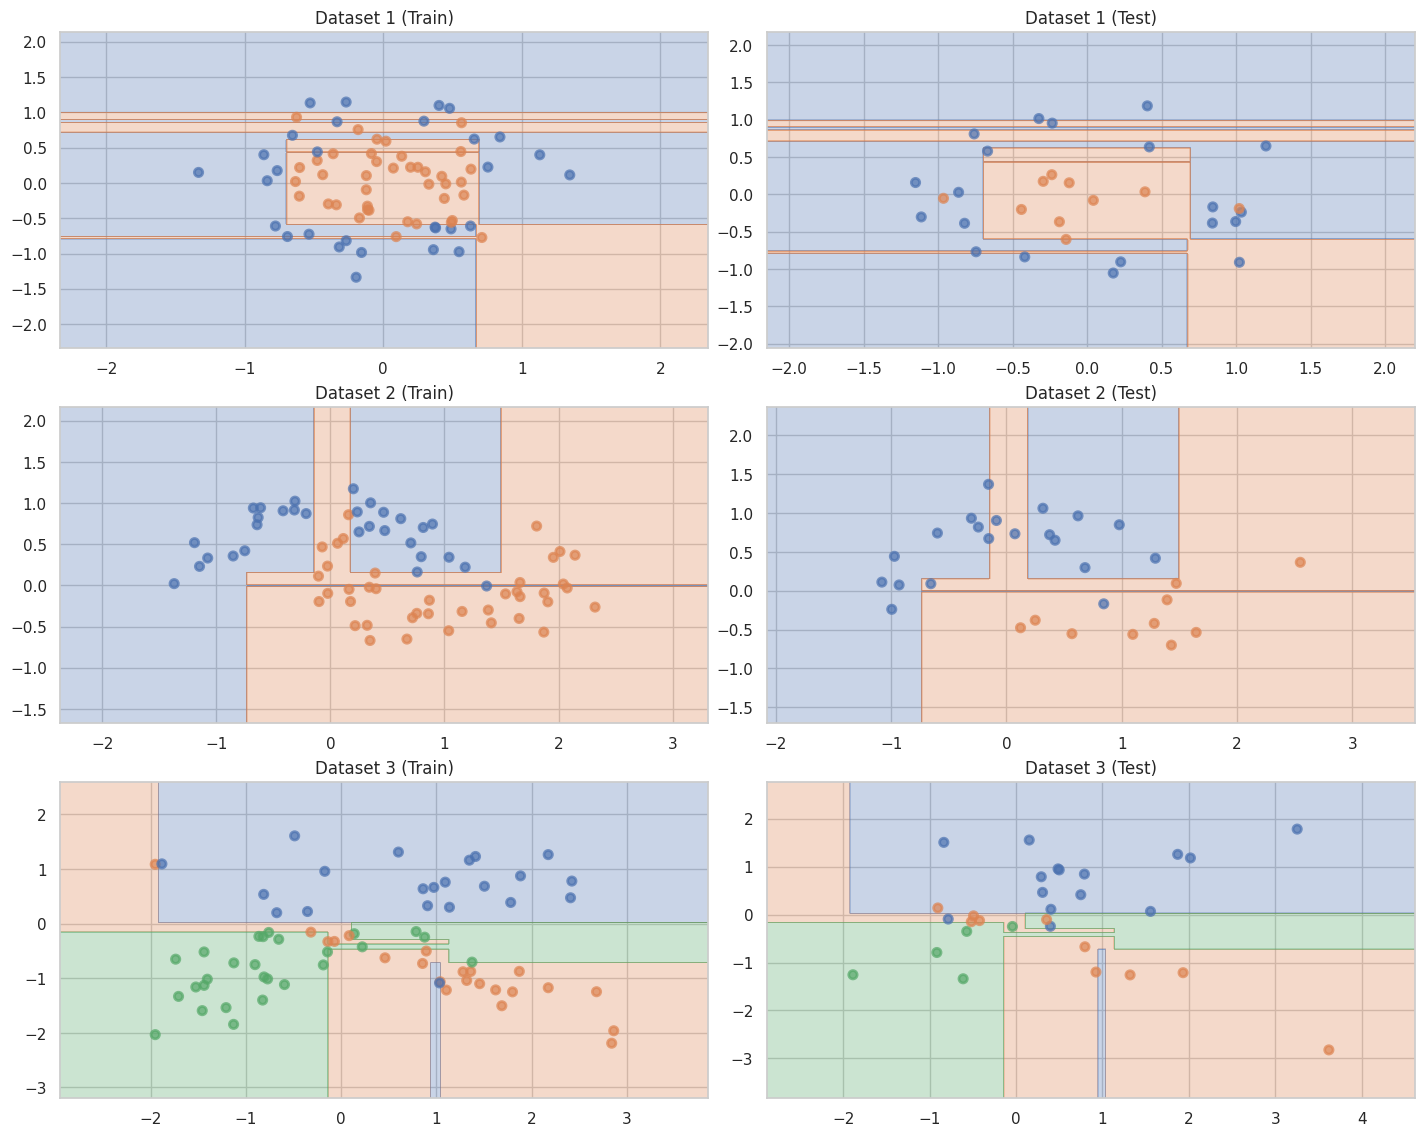

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

plt.figure(figsize=(15, 12))

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    tree = DecisionTreeClassifier(random_state=42)
    tree.fit(X_train, y_train)

    plt.subplot(3, 2, 2*i + 1)
    plot_surface(tree, X_train, y_train)
    plt.title(f'Dataset {i+1} (Train)')

    plt.subplot(3, 2, 2*i + 2)
    plot_surface(tree, X_test, y_test)
    plt.title(f'Dataset {i+1} (Test)')

    train_acc = accuracy_score(y_train, tree.predict(X_train))
    test_acc = accuracy_score(y_test, tree.predict(X_test))

    print(f'Dataset {i+1}:')
    print(f'Train accuracy: {train_acc:.3f}')
    print(f'Test accuracy: {test_acc:.3f}')
    print('---')

__Ответ:__ решающие деревья с параметрами по умолчанию демонстрируют сильное переобучение на всех трех датасетах:

- на обучающей выборке accuracy достигает 1.0, деревья идеально подстроились под тренировочные данные
- на тестовой выборке:

Для make_circles (Dataset 1) — 0.733

Для make_moons (Dataset 2) — 0.867

Для make_classification (Dataset 3) — 0.833

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?


=== Parameters: max_depth=1, min_samples_leaf=1 ===
Dataset 1:
Train accuracy: 0.729, Test accuracy: 0.467
Degree of overfitting: 0.262
Dataset 2:
Train accuracy: 0.843, Test accuracy: 0.800
Degree of overfitting: 0.043
Dataset 3:
Train accuracy: 0.671, Test accuracy: 0.600
Degree of overfitting: 0.071

=== Parameters: max_depth=3, min_samples_leaf=1 ===
Dataset 1:
Train accuracy: 0.886, Test accuracy: 0.733
Degree of overfitting: 0.152
Dataset 2:
Train accuracy: 0.914, Test accuracy: 0.933
Degree of overfitting: -0.019
Dataset 3:
Train accuracy: 0.943, Test accuracy: 0.867
Degree of overfitting: 0.076

=== Parameters: max_depth=5, min_samples_leaf=5 ===
Dataset 1:
Train accuracy: 0.871, Test accuracy: 0.900
Degree of overfitting: -0.029
Dataset 2:
Train accuracy: 0.957, Test accuracy: 0.733
Degree of overfitting: 0.224
Dataset 3:
Train accuracy: 0.900, Test accuracy: 0.700
Degree of overfitting: 0.200

=== Parameters: max_depth=None, min_samples_leaf=10 ===
Dataset 1:
Train accuracy:

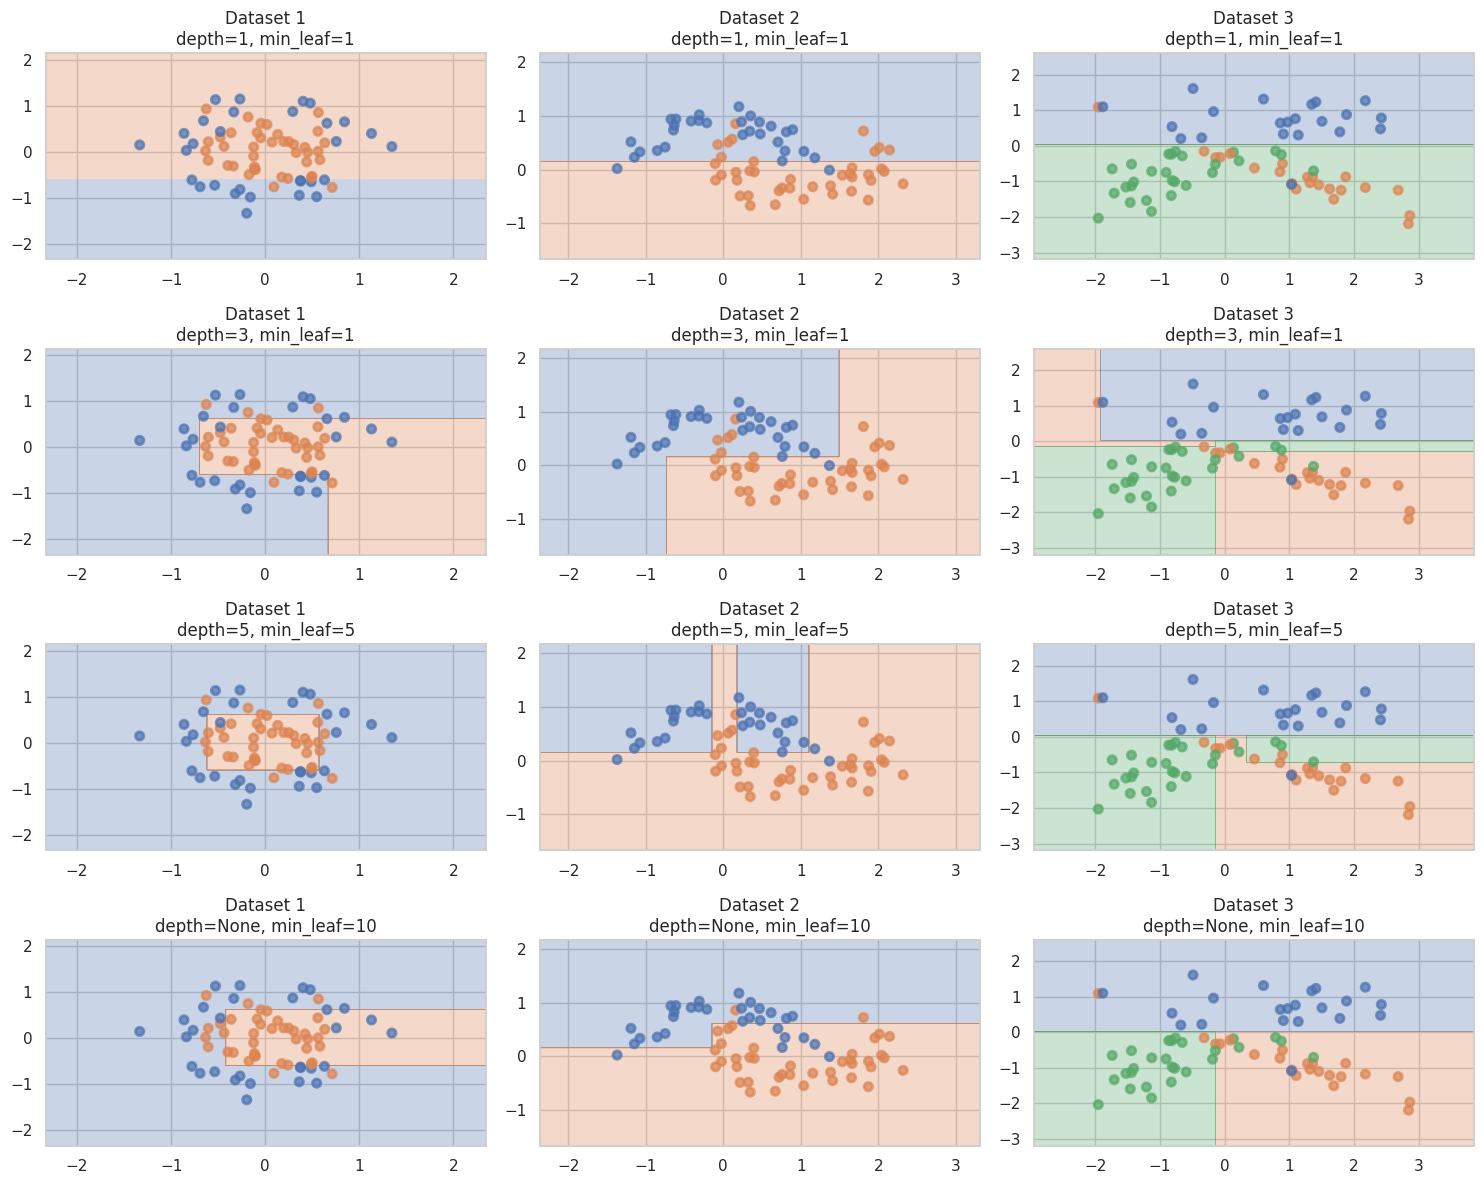

In [9]:
param_grid = [
    {'max_depth': 1, 'min_samples_leaf': 1},
    {'max_depth': 3, 'min_samples_leaf': 1},
    {'max_depth': 5, 'min_samples_leaf': 5},
    {'max_depth': None, 'min_samples_leaf': 10}
]

plt.figure(figsize=(15, 12))
row = 0

for params in param_grid:
    row += 1
    print(f"\n=== Parameters: max_depth={params['max_depth']}, min_samples_leaf={params['min_samples_leaf']} ===")

    for i, (X, y) in enumerate(datasets):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        tree = DecisionTreeClassifier(
            max_depth=params['max_depth'],
            min_samples_leaf=params['min_samples_leaf'],
            random_state=42
        )
        tree.fit(X_train, y_train)

        plt.subplot(len(param_grid), 3, (row-1)*3 + i + 1)
        plot_surface(tree, X_train, y_train)
        plt.title(f'Dataset {i+1}\ndepth={params["max_depth"]}, min_leaf={params["min_samples_leaf"]}')

        train_acc = accuracy_score(y_train, tree.predict(X_train))
        test_acc = accuracy_score(y_test, tree.predict(X_test))
        overfit = train_acc - test_acc

        print(f"Dataset {i+1}:")
        print(f"Train accuracy: {train_acc:.3f}, Test accuracy: {test_acc:.3f}")
        print(f"Degree of overfitting: {overfit:.3f}")

plt.tight_layout()
plt.show()

__Ответ:__

для max_depth:

- если глубина слишком маленькая (например, 1), дерево почти ничего не понимает — получается недообучение
- при средней глубине (3–5) — как раз оптимально: и модель учится, и не переусложняется
- без ограничений (None) — дерево запоминает слишком много, начинает переобучаться

для min_samples_leaf:

- если маленькое значение (например, 1), дерево может подгоняться под шум
- если увеличить до 5 или 10, дерево становится аккуратнее и обобщает лучше

1) Dataset 1:

лучше всего сработало: max_depth=5, min_samples_leaf=5 — точность на тесте 90%.

при маленькой глубине дерево не справляется.

очень чувствительно к настройке параметров, легко переобучается или недообучается

2) Dataset 2:

оптимально: max_depth=3, min_samples_leaf=1 — точность 93.3%

если глубина больше (например, 5), модель начинает переобучаться

в целом хорошо работает с умеренной сложностью дерева

3) Dataset 3:

лучшая настройка: max_depth=3, min_samples_leaf=1 — точность 86.7%

менее чувствителен к параметрам, чем первые два датасета

переобучение проявляется, но не так сильно

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

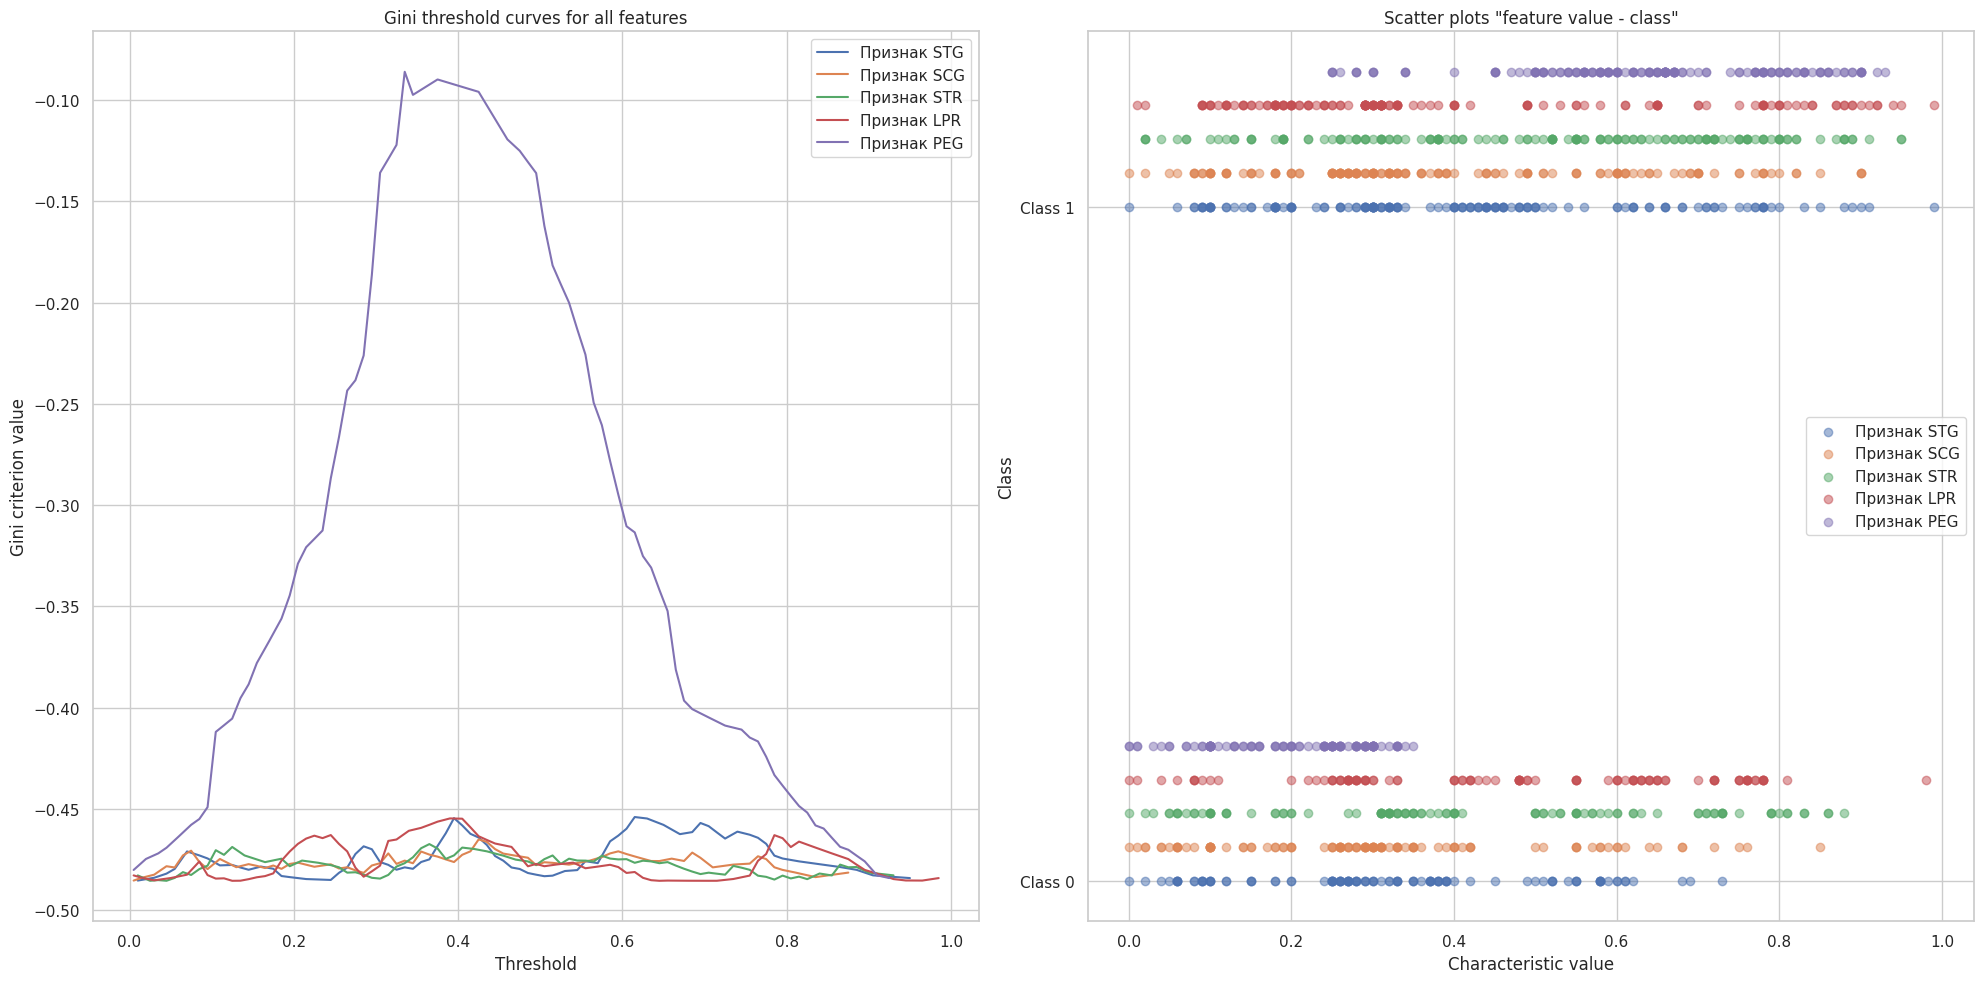

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

data = pd.read_csv('students.csv')
features = data.iloc[:, :5]
target = data.iloc[:, 5]

def find_best_split(feature_vector, target_vector):
    sorted_idx = np.argsort(feature_vector)
    sorted_feature = feature_vector[sorted_idx]
    sorted_target = target_vector[sorted_idx]

    thresholds = (sorted_feature[1:] + sorted_feature[:-1]) / 2
    unique_thresh_idx = np.where(np.diff(sorted_feature) != 0)[0]
    thresholds = thresholds[unique_thresh_idx]

    if len(thresholds) == 0:
        return None, None, None, None

    left_cumsum = np.cumsum(sorted_target[:-1])[unique_thresh_idx]
    left_total = np.arange(1, len(sorted_feature))[unique_thresh_idx]
    left_p1 = left_cumsum / left_total
    left_p0 = 1 - left_p1

    right_cumsum = np.sum(sorted_target) - left_cumsum
    right_total = len(sorted_feature) - left_total
    right_p1 = right_cumsum / right_total
    right_p0 = 1 - right_p1

    H_left = 1 - left_p0**2 - left_p1**2
    H_right = 1 - right_p0**2 - right_p1**2
    ginis = -(left_total/len(sorted_feature))*H_left - (right_total/len(sorted_feature))*H_right

    return thresholds, ginis, thresholds[np.argmax(ginis)], np.max(ginis)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
for i, col in enumerate(features.columns):
    thresholds, ginis, _, _ = find_best_split(features[col].values, target.values)
    if thresholds is not None:
        plt.plot(thresholds, ginis, label=f'Признак {col}')
plt.xlabel('Threshold')
plt.ylabel('Gini criterion value')
plt.title('Gini threshold curves for all features')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i, col in enumerate(features.columns):
    plt.scatter(features[col], target + i*0.05, label=f'Признак {col}', alpha=0.5)
plt.yticks([0, 1], ['Class 0', 'Class 1'])
plt.xlabel('Characteristic value')
plt.ylabel('Class')
plt.title('Scatter plots "feature value - class"')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**
судя по графикам значений критерия Джини, выборку стоит делить по тому признаку, у которого кривая Джини поднимается выше всех — это значит, что при каком-то пороге этот признак хорошо разделяет объекты на классы. Обычно это видно по резкому пику на графике, где значение Джини близко к 0.5 — такой признак можно считать "хорошим". Это подтверждается и scatter-графиками: если классы чётко отделены друг от друга вдоль оси этого признака, значит, разбиение будет удачным. Кривые для таких признаков выглядят как один или несколько резких пиков — это значит, что есть конкретный порог, при котором классы делятся почти идеально. А вот у "плохих" признаков кривая Джини почти плоская, без ярко выраженных пиков, и значения близки к нулю — это значит, что вне зависимости от порога классы сильно перемешаны, и нормального разбиения не получится.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from hw2code import DecisionTree

df = pd.read_csv('agaricus-lepiota.data', header=None)

label_encoders = []
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders.append(le)

y = df.iloc[:, 0].values
X = df.iloc[:, 1:].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

feature_types = ['categorical'] * X.shape[1]

tree = DecisionTree(feature_types=feature_types, max_depth=None)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc:.3f}")

def compute_tree_depth(node):
    if node["type"] == "terminal":
        return 1
    else:
        left_depth = compute_tree_depth(node["left_child"])
        right_depth = compute_tree_depth(node["right_child"])
        return 1 + max(left_depth, right_depth)

depth = compute_tree_depth(tree._tree)
print(f"Depth: {depth}")

Accuracy: 1.000
Depth: 9


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from hw2code import DecisionTree

In [30]:
df = pd.read_csv('tic-tac-toe-endgame.csv')

X = df.drop(columns='V10')
X_encoded = np.zeros_like(X, dtype=int)

for i, col in enumerate(X.columns):
    le = LabelEncoder()
    X_encoded[:, i] = le.fit_transform(X[col])

y = (df['V10'] == 'positive').astype(int).values
feature_types = ['categorical'] * X_encoded.shape[1]

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42
)

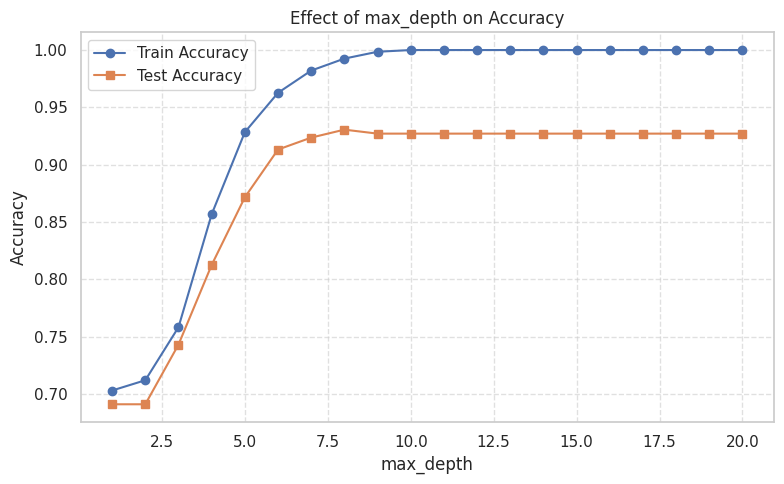

In [31]:
train_scores = []
test_scores = []

for val in range(1, 21):
    tree = DecisionTree(
        feature_types=feature_types,
        max_depth=val,
        min_samples_split=2,
        min_samples_leaf=1
    )
    tree.fit(X_train, y_train)
    train_pred = tree.predict(X_train)
    test_pred = tree.predict(X_test)

    train_scores.append(accuracy_score(y_train, train_pred))
    test_scores.append(accuracy_score(y_test, test_pred))

plt.figure(figsize=(8, 5))
plt.plot(range(1, 21), train_scores, label='Train Accuracy', marker='o')
plt.plot(range(1, 21), test_scores, label='Test Accuracy', marker='s')
plt.title('Effect of max_depth on Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

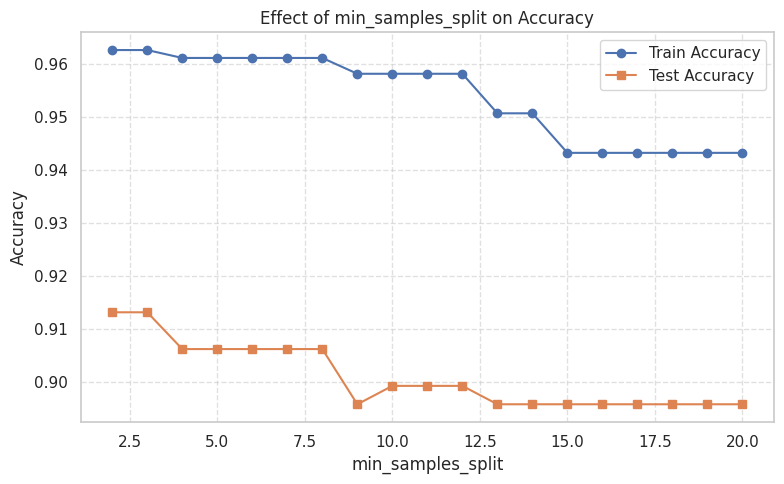

In [32]:
train_scores = []
test_scores = []

for val in range(2, 21):
    tree = DecisionTree(
        feature_types=feature_types,
        max_depth=6,
        min_samples_split=val,
        min_samples_leaf=1
    )
    tree.fit(X_train, y_train)
    train_pred = tree.predict(X_train)
    test_pred = tree.predict(X_test)

    train_scores.append(accuracy_score(y_train, train_pred))
    test_scores.append(accuracy_score(y_test, test_pred))

plt.figure(figsize=(8, 5))
plt.plot(range(2, 21), train_scores, label='Train Accuracy', marker='o')
plt.plot(range(2, 21), test_scores, label='Test Accuracy', marker='s')
plt.title('Effect of min_samples_split on Accuracy')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


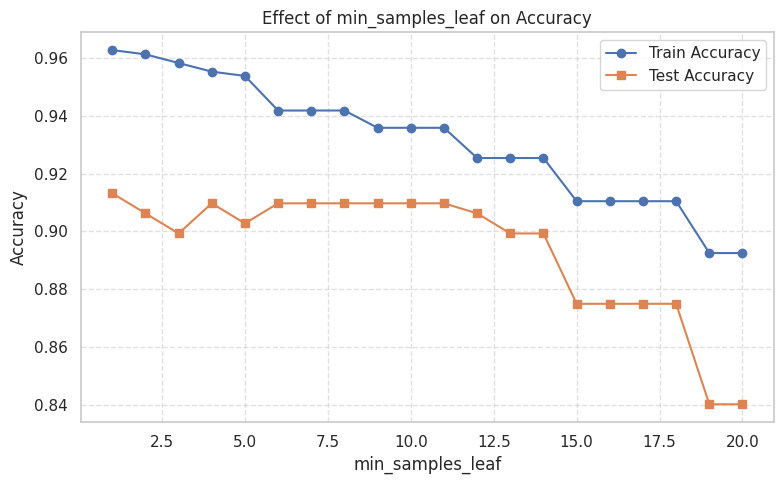

In [33]:
train_scores = []
test_scores = []

for val in range(1, 21):
    tree = DecisionTree(
        feature_types=feature_types,
        max_depth=6,
        min_samples_split=2,
        min_samples_leaf=val
    )
    tree.fit(X_train, y_train)
    train_pred = tree.predict(X_train)
    test_pred = tree.predict(X_test)

    train_scores.append(accuracy_score(y_train, train_pred))
    test_scores.append(accuracy_score(y_test, test_pred))

plt.figure(figsize=(8, 5))
plt.plot(range(1, 21), train_scores, label='Train Accuracy', marker='o')
plt.plot(range(1, 21), test_scores, label='Test Accuracy', marker='s')
plt.title('Effect of min_samples_leaf on Accuracy')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer

In [16]:
class CustomDecisionTree:
    def __init__(self, feature_types):
        self.feature_types = feature_types
        self.model = DecisionTreeClassifier()

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

In [17]:
class ContinuousTreeWrapper:
    def __init__(self):
        self.tree = None

    def fit(self, X, y):
        self.tree = CustomDecisionTree(['continuous'] * X.shape[1])
        data = X.values if hasattr(X, 'values') else X
        self.tree.fit(data.astype(float), y.values if hasattr(y, 'values') else y)
        return self

    def predict(self, X):
        data = X.values if hasattr(X, 'values') else X
        return self.tree.predict(data.astype(float))

    def get_params(self, deep=True):
        return {}

class CategoricalTreeWrapper:
    def __init__(self):
        self.tree = None

    def fit(self, X, y):
        self.tree = CustomDecisionTree(['categorical'] * X.shape[1])
        data = X.values if hasattr(X, 'values') else X
        self.tree.fit(data, y.values if hasattr(y, 'values') else y)
        return self

    def predict(self, X):
        data = X.values if hasattr(X, 'values') else X
        return self.tree.predict(data)

    def get_params(self, deep=True):
        return {}

class OneHotTreeWrapper:
    def __init__(self):
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.tree = None

    def fit(self, X, y):
        data = X.values if hasattr(X, 'values') else X
        self.encoder.fit(data)
        transformed = self.encoder.transform(data)
        self.tree = CustomDecisionTree(['continuous'] * transformed.shape[1])
        self.tree.fit(transformed, y.values if hasattr(y, 'values') else y)
        return self

    def predict(self, X):
        data = X.values if hasattr(X, 'values') else X
        transformed = self.encoder.transform(data)
        return self.tree.predict(transformed)

    def get_params(self, deep=True):
        return {}

In [18]:
mushroom_data = pd.read_csv('agaricus-lepiota.data', header=None)
tic_data = pd.read_csv('tic-tac-toe-endgame.csv')
car_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header=None)
nursery_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', header=None)

tic_target = tic_data.columns[-1]
car_target = car_data.columns[-1]
nursery_target = nursery_data.columns[-1]

mushroom_data[0] = mushroom_data[0].map({'p': 0, 'e': 1})
tic_data[tic_target] = tic_data[tic_target].map({'negative': 0, 'positive': 1})
car_data[car_target] = car_data[car_target].map({'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1})
nursery_data[nursery_target] = nursery_data[nursery_target].map({
    'not_recom': 0, 'recommend': 0,
    'very_recom': 1, 'priority': 1, 'spec_prior': 1
})

datasets = {
    'Mushrooms': (mushroom_data, 0),
    'TicTacToe': (tic_data, tic_target),
    'Cars': (car_data, car_target),
    'Nursery': (nursery_data, nursery_target)
}

label_enc = LabelEncoder()
for name, (df, target_col) in datasets.items():
    features = [c for c in df.columns if c != target_col]
    for col in features:
        df[col] = label_enc.fit_transform(df[col].astype(str))

In [19]:
model_variants = {
    'ContTree': ContinuousTreeWrapper(),
    'CatTree': CategoricalTreeWrapper(),
    'OHOTree': OneHotTreeWrapper(),
    'SKTree': DecisionTreeClassifier()
}

accuracy = make_scorer(accuracy_score)
summary = []

for dataset_name, (df, target_col) in datasets.items():
    if isinstance(target_col, int) and target_col < 0:
        X = df.iloc[:, :target_col]
        y = df.iloc[:, target_col]
    else:
        X = df.drop(columns=target_col)
        y = df[target_col]

    scores = {'Dataset': dataset_name}

    for model_name, model in model_variants.items():
        try:
            cv_scores = cross_val_score(model, X, y, cv=10, scoring=accuracy)
            scores[model_name] = np.mean(cv_scores)
        except Exception as ex:
            scores[model_name] = f"Fail: {ex}"

    summary.append(scores)

results = pd.DataFrame(summary).set_index('Dataset')


In [21]:
pd.options.display.float_format = '{:.4f}'.format
print("Comparison of models by accuracy:")
print(results)

Comparison of models by accuracy:
           ContTree  CatTree  OHOTree  SKTree
Dataset                                      
Mushrooms    0.9993   0.9993   1.0000  0.9567
TicTacToe    0.4738   0.4676   0.5519  0.7873
Cars         0.9351   0.9397   0.9131  0.9433
Nursery      0.9997   0.9997   0.9997  0.9997


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента.
Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.

Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

в этом эксперименте видно, что одни и те же алгоритмы работают по-разному на разных наборах данных. например, в наборах Mushrooms и Nursery все деревья справляются почти одинаково хорошо — точность почти 100%, а вот в TicTacToe разница большая: одни модели дают плохие результаты, другие хорошие.

причина в типах признаков. в Mushrooms и Nursery признаки простые и категориальные. такие признаки сами по себе хорошо делят данные, поэтому деревья быстро находят правильные правила. вот в TicTacToe важна комбинация нескольких признаков одновременно, и простое числовое кодирование тут не помогает. One-hot кодирование лучше передаёт структуру, поэтому такая модель работает лучше.

также в результатах есть немного случайности, потому что каждый раз данные делятся по-разному при кросс-валидации. Из-за этого точность может немного меняться. чтобы это исправить, можно сделать побольше разбиений

Вставьте что угодно, описывающее ваши впечатления от этого задания: